In [1]:
%load_ext autoreload
%autoreload 2
!pip install numpy
import yaml
import torch
import mlflow
import numpy
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from src.models.model_factory import ModelFactory
from src.data.human_ai_dataset import HumanVSAIDataset
from src.training.trainer import ModelTrainer
import torch.utils.data.dataset
import random
import torch.utils
import torch.utils.data
from src.utils.model_utils import save_model

## Configuration

In [9]:
%load_ext autoreload
%autoreload 2

def load_config(path):
    with open(path, 'r') as f:
        return yaml.safe_load(f)

config = load_config('config/config.yaml')
print("Loaded configuration")
print(yaml.dump(config, default_flow_style=False))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded configuration
dataset:
  test_csv: dataset/test.csv
  test_path: dataset/test_data_v2
  test_split: 0.3
  train_csv: dataset/train.csv
  train_path: dataset/train_data
hyperparameter_search:
  batch_size:
  - 32
  - 64
  - 128
  learning_rate:
  - 0.001
  - 0.01
  - 0.1
model_names:
- resnet
models:
  deep_cnn:
    base_params:
      in_channels_list:
      - 3
      - 32
      - 64
      - 128
      kernel_size_list:
      - 3
      - 3
      - 3
      - 3
      out_channels_list:
      - 32
      - 64
      - 128
      - 256
    parameter_search:
      dropout_rate:
      - 0.5
      - 0.4
      - 0.3
  hybrid_classifier:
    base_params: null
    parameter_search: null
  resnet:
    base_params:
      num_classes: 1
    parameter_search: null
training:
  classification_threshold: 0.5
  cross_validation:
    n_splits: 5
    shuffle: true
  early_stopping:
    min_delta: 0.001
    patience: 

## Data Loading and Preprocessing

In [10]:
labels_map = {
    0: 'Human generated',
    1: 'AI generated'
}

# NOTE: use this for validation set
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     # transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5],
#                         std=[0.5, 0.5, 0.5])
# ])

transform = transforms.Compose([
    # Random crop and resize the image to 128x128
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Random crop with scaling
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(30),  # Random rotation within a range of -30 to +30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color adjustments
    # transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize image to [-1, 1]
])

dataset = HumanVSAIDataset(
    annotations_file_path=config['dataset']['train_csv'],
    transform=transform
)

trainset_size = 1 - config['dataset']['test_split']
trainset_size = int(len(dataset) * trainset_size)
valset_size = int(len(dataset) - trainset_size)

trainset, valset = torch.utils.data.random_split(dataset, [trainset_size, valset_size])

print(f"Total trainset size: {len(dataset)}")
print(f"Training dataset size: {len(trainset)}")
print(f"Validation dataset size: {len(valset)}")

trainloader = torch.utils.data.DataLoader(trainset)

Total trainset size: 79950
Training dataset size: 55965
Validation dataset size: 23985


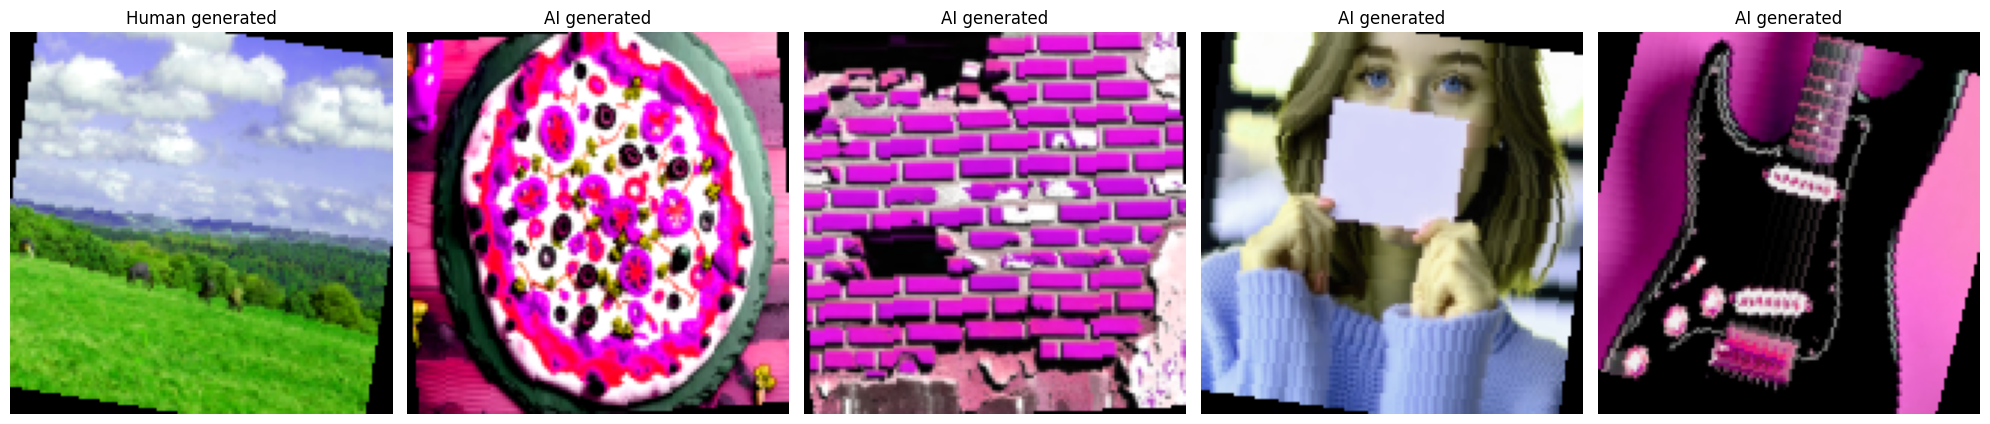

In [11]:
def show_batch(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        img, label = dataset[i]


        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0)

        img = (img - img.min()) / (img.max() - img.min())
        axes[i].imshow(img)
        axes[i].set_title(labels_map[label])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_batch(trainset)

In [13]:
%load_ext autoreload
%autoreload 2

model_factory = ModelFactory()
trainer = ModelTrainer(config, model_factory)

# Perform hyperparameter tuning
best_params, best_score, final_model = trainer.train_and_tune(trainset)

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")
save_model(best_params, best_score, final_model, 'resNet')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Skipping hyperparameter tuning and using default parameters.
Training resnet with default parameters
Performing KFold Cross Validation with 5 folds
Epoch 1


Training:  98%|█████████▊| 1374/1400 [1:02:33<01:11,  2.73s/it, loss=0.361, acc=84.4]


KeyboardInterrupt: 

In [ ]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history['train_loss'], label='Train')
    ax1.plot(history['val_loss'], label='Validation')
    ax1.set_title('Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(history['train_acc'], label='Train')
    ax2.plot(history['val_acc'], label='Validation')
    ax2.set_title('Accuracy Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(trainer.history)

In [ ]:
valloader = torch.utils.data.DataLoader(valset)
val_loss, val_acc = trainer._evaluate(final_model, valloader)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_acc}')

In [ ]:
model_factory = ModelFactory()
model_name = config['model_names'][0]

base_params = config['models'][model_name].get('base_params') or {}  # Fallback to empty dict if None
model = model_factory.get_model(model_name, **base_params)
model_path = "trained_models/resNet.pt"

ModelTrainer.test_random(
    model_path=model_path,
    model=model,
    num_images=3,
    csv_path="dataset/test.csv"
)